In [95]:
import cv2
import tensorflow as tf

from glob import glob
import itertools

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import imgaug.augmenters as iaa
from imgaug import parameters as iap

In [4]:
# Function to preprocess an image with histogram equalization
def preprocess_image(image_path, mask_path):
    # Read an image from a file
    image_string = tf.io.read_file(image_path)
    mask_string = tf.io.read_file(mask_path)
    # print(image_string, mask_string)
    # Decode it into a dense vector
    image_decoded = tf.image.decode_jpeg(image_string, channels=3)
    image_equalized = tf.numpy_function(equalize_histogram, [image_decoded], tf.float32)
    
    # Normalize the image
    image_output = (image_equalized - tf.reduce_min(image_equalized)) / (tf.reduce_max(image_equalized) - tf.reduce_min(image_equalized))
    
    mask_decoded = tf.image.decode_jpeg(mask_string, channels=1)
    
    # Ensure mask_output is of type float32
    mask_output = tf.cast(mask_decoded, tf.float32)
    
    return (image_output, mask_output)


# Function to apply histogram equalization to an image
def equalize_histogram(image):
    # Convert RGB to YUV
    image_yuv = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    # Apply histogram equalization to the Y channel
    image_yuv[:,:,0] = cv2.equalizeHist(image_yuv[:,:,0])
    # Convert YUV back to RGB
    image_output = cv2.cvtColor(image_yuv, cv2.COLOR_YUV2RGB)
    image_output = tf.convert_to_tensor(image_output, dtype=tf.float32)
    return image_output

# Load your image and mask data
image_path = 'vignettes/rgb\\rgb_305_6780\\rgb_35_305000_6780000.jpg'# 'vignettes/rgb/rgb_305_6785/rgb_35_305000_6781000.jpg'
mask_path = 'vignettes/mask\\mask_305_6780\\mask_35_305000_6780000.png'

# Preprocess the image and mask
image, mask = preprocess_image(image_path, mask_path)

In [27]:
BATCH_SIZE = 32 # Big enough to measure an F1-score
AUTOTUNE = tf.data.experimental.AUTOTUNE # Adapt preprocessing and prefetching dynamically
SHUFFLE_BUFFER_SIZE = 1024 # Shuffle the training data by a chunck of 1024 observations
CHANNELS = 3
IMG_SIZE = 256

In [6]:
rgb_img_paths = sorted(
    list(
        itertools.chain.from_iterable(
            [glob(i + "*.jpg") for i in glob("vignettes/rgb/*/", recursive = True)]
        )
    )
)
masks_img_paths = sorted(
    list(
        itertools.chain.from_iterable(
            [glob(i + "*.png") for i in glob("vignettes/mask/*/", recursive = True)]
        )
    )
)

In [7]:
# Create a first dataset of file paths and labels
dataset = tf.data.Dataset.from_tensor_slices((rgb_img_paths, masks_img_paths))

In [8]:
dataset = dataset.map(preprocess_image, num_parallel_calls=AUTOTUNE)

In [9]:
elem = next(iter(dataset))


In [126]:
# Function to apply data augmentation to an image and its mask
def augment_data(image, mask):
    image = tf.image.convert_image_dtype(image, tf.uint8)
    mask = tf.image.convert_image_dtype(mask, tf.uint8)
    
    seq = iaa.Sequential([
        iaa.Crop(percent=(0, 0.3), keep_size=True),
        iaa.Grayscale(alpha=iap.Choice([0, 1.0], p=[0.5, 0.5])),
        iaa.Fliplr(0.5),
        iaa.Flipud(0.5),
        iaa.GaussianBlur(sigma=(0.0, 0.2))
    ])
    
    aug_det = seq.to_deterministic()
    image_aug = aug_det.augment_image(image.numpy())
    mask_aug = aug_det.augment_image(mask.numpy())
    
    image_aug = tf.image.convert_image_dtype(image_aug, tf.float32)
    mask_aug = tf.image.convert_image_dtype(mask_aug, tf.float32)
    
    return image_aug, mask_aug


# Apply data augmentation
image_aug, mask_aug = augment_data(elem[0], elem[1])

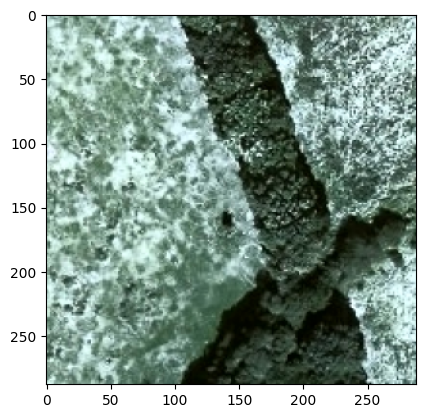

In [127]:
plt.imshow(image_aug)

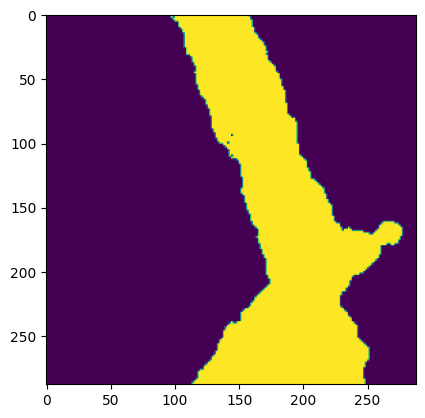

In [128]:
plt.imshow(mask_aug)

In [129]:
serie_combined_dataset = pd.Series(combined_dataset.as_numpy_iterator())#.map(lambda x: augment_data(x[0], x[1]))

In [130]:
serie_combined_dataset.map(lambda x: augment_data(x[0], x[1]))

AssertionError: Expected number of channels to be three, got 1 channels (shape (288, 288, 1)).

In [19]:
# Function to generate new image and mask pairs
def generate_new_data():
    # You would implement this function to generate new image and mask pairs on-the-fly.
    # For this example, let's create dummy data.
    new_images = [tf.constant(image_aug)]
    new_masks = [tf.constant(mask_aug)]

    for image, mask in zip(new_images, new_masks):
        yield image, mask

# Create a dataset from the generator
new_dataset = tf.data.Dataset.from_generator(
    generate_new_data,
    output_signature=(
        tf.TensorSpec(shape=(288, 288, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(288, 288, 1), dtype=tf.float32),
    ),
)

In [20]:
new_elem = next(iter(new_dataset))

In [21]:
combined_dataset = dataset.concatenate(new_dataset)

In [22]:
combined_elem = next(iter(combined_dataset))

In [24]:
last_elem = list(combined_dataset.as_numpy_iterator())[-1]

In [26]:
len(list(combined_dataset.as_numpy_iterator()))

1405